In [1]:
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt
import matplotlib as mpl 
import matplotlib.dates as mdates

In [2]:
# local libraries
from glofrim import PCR_model, CMF_model, LFP_model
from glofrim.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'couplingSettings_LFP.set'
argv2 = r'modelPaths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2001-12-31 00:00:00
730


In [4]:
# setup output dir
in_dir = options['GENERAL']['inputDir']
out_dir = options['GENERAL']['outputDir'] + 'PCR2LFP/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(in_dir)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2LFP/
/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(in_dir, options['hydrologic_model']['config_file'])
PCR_in_dir = os.path.join(os.path.dirname(PCR_config_fn), 'input30min')
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)


/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/PCR_Elbe/input30min
/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2LFP/PCR


## create LFP model BMI object

In [6]:
LFP_engine = options['LFP_engine']['LFP_path']
LFP_config_fn = os.path.join(in_dir, options['hydrodynamic_model']['model_file'])
LFP_model_dir = os.path.dirname(LFP_config_fn)
LFP_out_dir = os.path.join(out_dir, 'LFP')
print(LFP_engine)
print(LFP_model_dir)
print(LFP_config_fn)
print(LFP_out_dir)


LFP_bmi = LFP_model(LFP_engine, LFP_config_fn, LFP_model_dir, LFP_out_dir,
                              start_date, end_date)

/home/jannis/Programmes/lisflood-bmi-v5.9/liblisflood.so
/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/LFP_data
/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/LFP_data/LFPmodel_Elbe.par
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2LFP/LFP


## intitialize LFP model first to expose 1d coords

In [7]:
# initialize LFP to expose model coordinates via BMI
LFP_bmi.initialize()

## set coupling between PCR and DFM

Couple external 1d coordinates to internal model 2d grid. 

From the green cells with value 1 (green) runoff is couled for the cells with value 2 (yellow) discharge is coupled

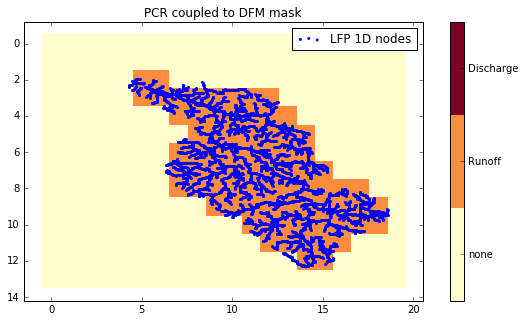

In [8]:
# get coupled dictionaries
PCR_bmi.couple_grid_to_1d(LFP_bmi)

# get DFM 1d nodes in local grid coordinates
x, y = zip(*LFP_bmi.model_1d_coords)
c, r = ~PCR_bmi.model_grid_transform * (np.atleast_1d(x), np.atleast_1d(y))
c, r = c-0.5, r-0.5

# set colorscheme
cmap=plt.cm.YlOrRd
bounds = np.linspace(-0.5,2.5,4)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# plot figure
fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(PCR_bmi.coupled_mask, interpolation='nearest', cmap=cmap, norm=norm)
# PCR_bmi.dd.plot_dd(ax=b, color='grey', label='PCR ldd')
b.scatter(c, r, s=4, color='b', label='LFP 1D nodes')
# fix colorbar
cbar = plt.colorbar()
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['none', 'Runoff', 'Discharge'])
b.set_title('PCR coupled to DFM mask')
# b.set_xlim([4, 13])
# b.set_ylim([7, 1])
plt.legend()

In [ ]:
# initialize PCR to after editing ldd grid
PCR_bmi.initialize()

## run coupled PCR - DFM model

In [ ]:

DFMidx = DFM_bmi.coupled_idx
DFM_area_1d = DFM_bmi.get_var('ba')[DFMidx]
PCRidx = PCR_bmi.coupled_idx
PCRfrac = PCR_bmi.coupled_area_frac

def set_DFM_forcing():
    PCR_delta_vol = PCR_bmi.get_coupled_flux() # 2d array [m3/day]
    print np.sum(PCR_delta_vol)
    DFM_depth_conservative = PCR_delta_vol[PCRidx] * PCRfrac / DFM_area_1d # 1d array for coupld DFM cells [m/day]
    zerorain = np.zeros_like(np.copy(DFM_bmi.get_var('rain')))
    DFM_bmi.set_var('rain', zerorain)
    DFM_bmi.set_var_index('rain', DFMidx, DFM_depth_conservative)
    return PCR_delta_vol

In [ ]:
tStart = datetime.now()
for i in range(timeSteps):
    PCR_bmi.update()
    set_DFM_forcing()
    DFM_bmi.update()  

In [ ]:
# get DFM 1d nodes in local grid coordinates
x, y = zip(*DFM_bmi.model_1d_coords) # only 1d coords
c, r = ~PCR_bmi.model_grid_transform * (np.atleast_1d(x), np.atleast_1d(y))
c, r = c-0.5, r-0.5
# set values to right index
plot_depth = np.zeros(len(r))
plot_depth[DFMidx - DFM_bmi._1d2d_idx] = DFM_bmi.get_var('s1')[DFMidx]

# plot figure

fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
im = plt.imshow(np.ma.masked_equal(PCR_bmi.get_coupled_flux(), 0), vmin=0, interpolation='nearest', cmap='Blues')
PCR_bmi.dd.plot_dd(ax=b, color='grey', label='PCR ldd')
im2 = b.scatter(c, r, s=4, c=plot_depth, cmap='YlOrRd') #, norm=mpl.colors.LogNorm())
# fix colorbar
cbar1 = plt.colorbar(im)
cbar1.set_label('PCR flux (runoff+discharge) [m3/day]')
cbar = plt.colorbar(im2)
cbar.set_label('DMF depth [m]')
b.set_title('PCR coupled to DFM flux')
b.set_xlim([4, 11])
b.set_ylim([5, 1])

In [ ]:
tEnd = datetime.now()

In [ ]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd

In [ ]:
DFM_bmi.finalize()
PCR_bmi.finalize()

In [ ]:
#- load DFM output file (from this model run)
%matplotlib inline
fo = os.path.join(DFM_out_dir, 'DFM_OUTPUT_DFM_Elbe_VU/', 'DFM_Elbe_VU_his.nc')
no = Dataset(fo, 'r')
#- extract simulated discharge from nc-file (for this run)
qsim = no.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC = np.absolute(qsim[:,2])
qsim_ND = np.absolute(qsim[:,0])
qsim_downBC = np.absolute(qsim[:,1])

#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(in_dir, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
no_stA = Dataset(fo_stA, 'r')
#- extract simulated discharge from nc-file for DFM standalone
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- load BfG file
vo = os.path.join(in_dir, 'test_Elbe/', 'Elbe-W+Q.csv')
#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- limit to list with least entries
minLength = min(len(qobs_ND), len(qsim_ND), len(qsim_ND_stA))
if len(qobs_ND) > len(qsim_ND):
    qsim_ND = qsim_ND[:minLength]
    qobs_ND = qobs_ND[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    
#- computed KGE at NeuDarchau
KGE_ND = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND)
KGE_ND = np.round(KGE_ND,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)

#- plot
plt.figure(figsize=(16,8))
plt.plot(qsim_ND, 'b', label = 'PCR->DFM')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(len(qsim_ND)+1,4900, 'KGEs') 
plt.text(len(qsim_ND)+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(len(qsim_ND)+1,4300, 'PCR->DFM : '+str(KGE_ND))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(out_dir, 'compareAndvalidate_Qsim_PCR2DFM.png'), dpi=300)